# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,ScalarOutcome, perform_experiments, ema_logging, SequentialEvaluator, MultiprocessingEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,

            'prey':prey}

In [8]:
model = Model("predprey", function=pred_prey)
model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                           RealParameter('predation_rate', 0.0005, 0.003),
                           RealParameter('predator_efficiency', 0.001, 0.004),
                           RealParameter('predator_loss_rate', 0.04, 0.08)
                          ]
model.outcomes = [TimeSeriesOutcome('prey'),
                      TimeSeriesOutcome('predators')
                     ]
model.run_length = int(1460)
model.replications = 5
N = 1000

# with MultiprocessingEvaluator(model) as evaluator:
with SequentialEvaluator(model) as evaluator: # MultiprocessingEvaluator does not work for me
    results = perform_experiments(model, scenarios=N, evaluator = evaluator, uncertainty_sampling="sobol")
experiments, outcomes = results

prey_final_sobol = outcomes['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes['prey'][:,0,:],axis=1)


[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


# Regression:

In [10]:
import statsmodels.api
import statsmodels.formula.api as ols
from patsy import dmatrices

cleaned_experiments = experiments.drop(columns=['scenario', 'policy', 'model'])
mod = statsmodels.regression.linear_model.OLS(prey_std_sobol, cleaned_experiments)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          3.912e+04
Date:                Fri, 15 May 2020   Prob (F-statistic):                        0.00
Time:                        16:18:50   Log-Likelihood:                         -27251.
No. Observations:               10000   AIC:                                  5.451e+04
Df Residuals:                    9996   BIC:                                  5.454e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

**Interpretation:**

All uncertainties have statistical regression to all KPI's (based on P value)  
Predation_rate and predator_efficiency both have largest effect on all of the outputs (based on theircoefficients)  
But this model is not linear so these statistics are practically useless



# SOBOL

{'S1': array([0.00169098, 0.7694395 , 0.17988582, 0.00227352]), 'S1_conf': array([0.00605665, 0.089673  , 0.03474719, 0.00887386]), 'ST': array([0.00519748, 0.81717184, 0.21899463, 0.01161008]), 'ST_conf': array([0.00099019, 0.05698842, 0.02356029, 0.00151572]), 'S2': array([[        nan, -0.00191167,  0.00315862,  0.00074765],
       [        nan,         nan,  0.05877703,  0.00859264],
       [        nan,         nan,         nan, -0.00722717],
       [        nan,         nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.01308608, 0.00987421, 0.00977584],
       [       nan,        nan, 0.15273101, 0.12854926],
       [       nan,        nan,        nan, 0.05982752],
       [       nan,        nan,        nan,        nan]])}


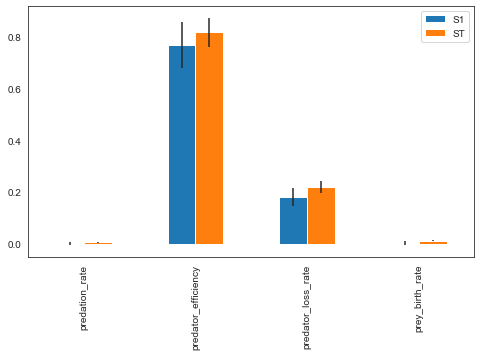

In [27]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, prey_mean_sobol,
                   calc_second_order=True, print_to_console=False)
print(Si)
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

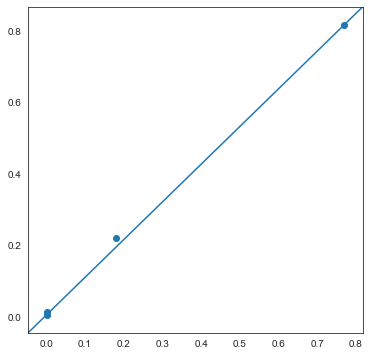

In [28]:
f, ax = plt.subplots(figsize = (6,6))
ax.scatter(indices['S1'], indices['ST'])
ax.plot([0, 1], [0, 1], transform=ax.transAxes)

plt.show()

**Interpretation:**

Predator_efficiency has largest effect on mean-prey. 

With prey_final_sobol as outcome, the ST counts up to about 1.8, so there are positive interaction effects. Direct effects (S1) counts up to 0.5. The great importance of interaction effects is not surprising, given the wave-like structure of the model behaviour.
With prey_std_sobol, the same applies but effects are even more noticeable.

Sample size:
This differs per outcome variable. With mean_prey, most confidence intervals are below 0.05, but with prey_final_sobol, the confidence intervals of ST are all greater than 0.05, meaning that these indices are not accurate yet, so more samples are needed, and the same goes for all from S1, but the last confidence interval.


# Extra trees Random forests

<function matplotlib.pyplot.show(*args, **kw)>

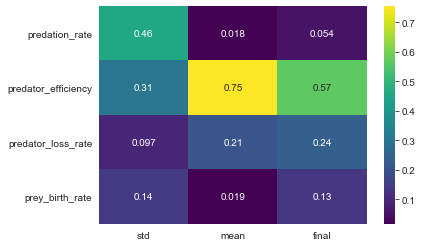

In [29]:
from ema_workbench.analysis import feature_scoring
dict_outcomes = {'std':prey_std_sobol, 'mean':prey_mean_sobol, 'final':prey_final_sobol}
scores = feature_scoring.get_feature_scores_all(cleaned_experiments, dict_outcomes)

sns.heatmap(scores, annot=True, cmap='viridis')
plt.show

**Interpretation:** 

The size/colours of the uncertainties is congruent with the sobol analyses. We can see for example that predator_efficiency is the most important preed in both the random trees as the sobol analysis.